In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df = pd.read_csv('data/user_behavior_dataset.csv', index_col='User ID')

In [3]:
df.head()

,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
User ID,,,,,,,,,,
1,Google Pixel 5,Android,393,6.40,1872,67,1122,40,Male,4
2,OnePlus 9,Android,268,4.70,1331,42,944,47,Female,3
3,Xiaomi Mi 11,Android,154,4.00,761,32,322,42,Male,2
4,Google Pixel 5,Android,239,4.80,1676,56,871,20,Male,3
5,iPhone 12,iOS,187,4.30,1367,58,988,31,Female,3


In [4]:
df.shape

(700, 10)

In [5]:
df.isnull().sum()

Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,User Behavior Class
count,700.00,700.00,700.00,700.00,700.00,700.00,700.00
mean,271.13,5.27,1525.16,50.68,929.74,38.48,2.99
std,177.20,3.07,819.14,26.94,640.45,12.01,1.40
min,30.00,1.00,302.00,10.00,102.00,18.00,1.00
25%,113.25,2.50,722.25,26.00,373.00,28.00,2.00
50%,227.50,4.90,1502.50,49.00,823.50,38.00,3.00
75%,434.25,7.40,2229.50,74.00,1341.00,49.00,4.00
max,598.00,12.00,2993.00,99.00,2497.00,59.00,5.00


In [8]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [9]:
df.head(3)

,device_model,operating_system,app_usage_time_(min/day),screen_on_time_(hours/day),battery_drain_(mah/day),number_of_apps_installed,data_usage_(mb/day),age,gender,user_behavior_class
User ID,,,,,,,,,,
1,Google Pixel 5,Android,393,6.40,1872,67,1122,40,Male,4
2,OnePlus 9,Android,268,4.70,1331,42,944,47,Female,3
3,Xiaomi Mi 11,Android,154,4.00,761,32,322,42,Male,2


We will convert app_usage_time from min/day to hrs/day

In [10]:
df['app_usage_time_(min/day)'] = df['app_usage_time_(min/day)']/60

In [11]:
df.rename(columns = {'app_usage_time_(min/day)': 'app_usage_time(hours/day)',
                     'screen_on_time_(hours/day)': 'screen_on_time(hours/day)',
                     'battery_drain_(mah/day)': 'battery_drain(mAh/day)',
                     'data_usage_(mb/day)': 'data_usage(mb/day)'}, inplace=True)

Since we are using user_behavior_class as our target variable, we will rename the column values from 1 as low and so on

In [12]:
rating_map = {
    1: 'Low',
    2: 'Below Average',
    3: 'Average',
    4: 'Above Average',
    5: 'High'
}

In [13]:
df['user_behavior_class'] = df['user_behavior_class'].replace(rating_map)

In [14]:
df.dtypes

device_model                  object
operating_system              object
app_usage_time(hours/day)    float64
screen_on_time(hours/day)    float64
battery_drain(mAh/day)         int64
number_of_apps_installed       int64
data_usage(mb/day)             int64
age                            int64
gender                        object
user_behavior_class           object
dtype: object

### EDA

<Figure size 1200x800 with 0 Axes>

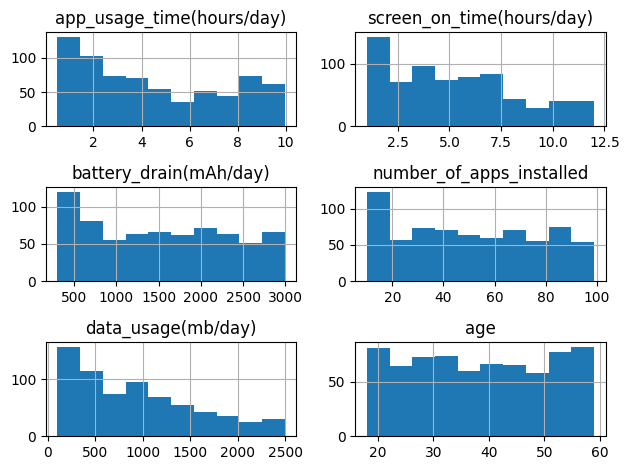

In [15]:
plt.figure(figsize=(12,8))
df.hist()
plt.tight_layout()
plt.show()

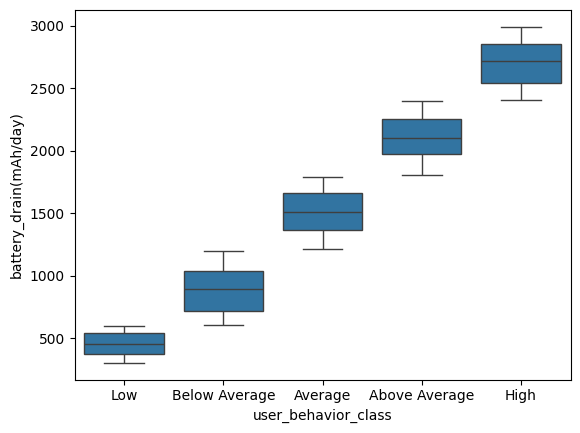

In [16]:
sns.boxplot(x = df['user_behavior_class'], y = df['battery_drain(mAh/day)'], order=['Low', 'Below Average', 'Average', 'Above Average', 'High'])
plt.show()

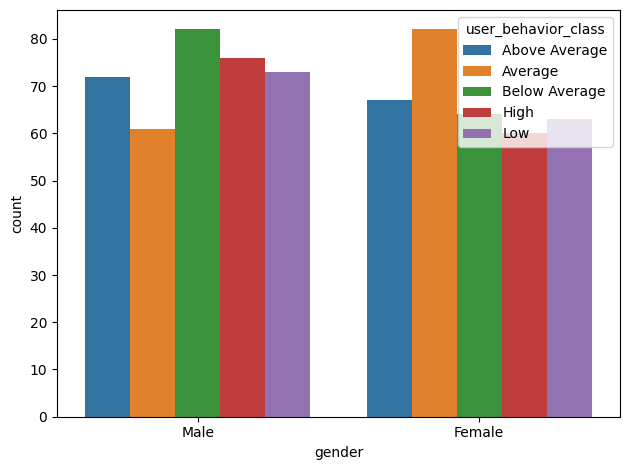

In [17]:
sns.countplot(x = df['gender'], hue=df['user_behavior_class'])
plt.tight_layout()
plt.show()

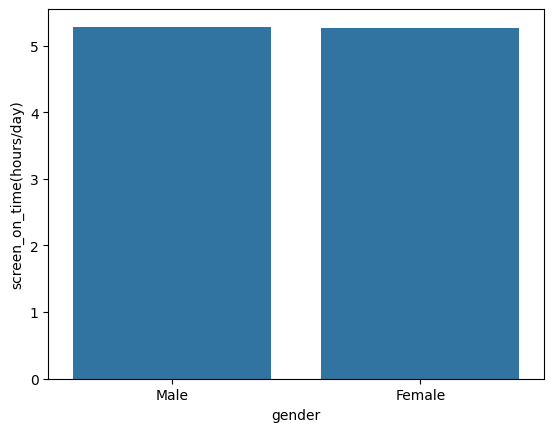

In [18]:
sns.barplot(x=df['gender'], y=df['screen_on_time(hours/day)'], errorbar=None)
plt.show()

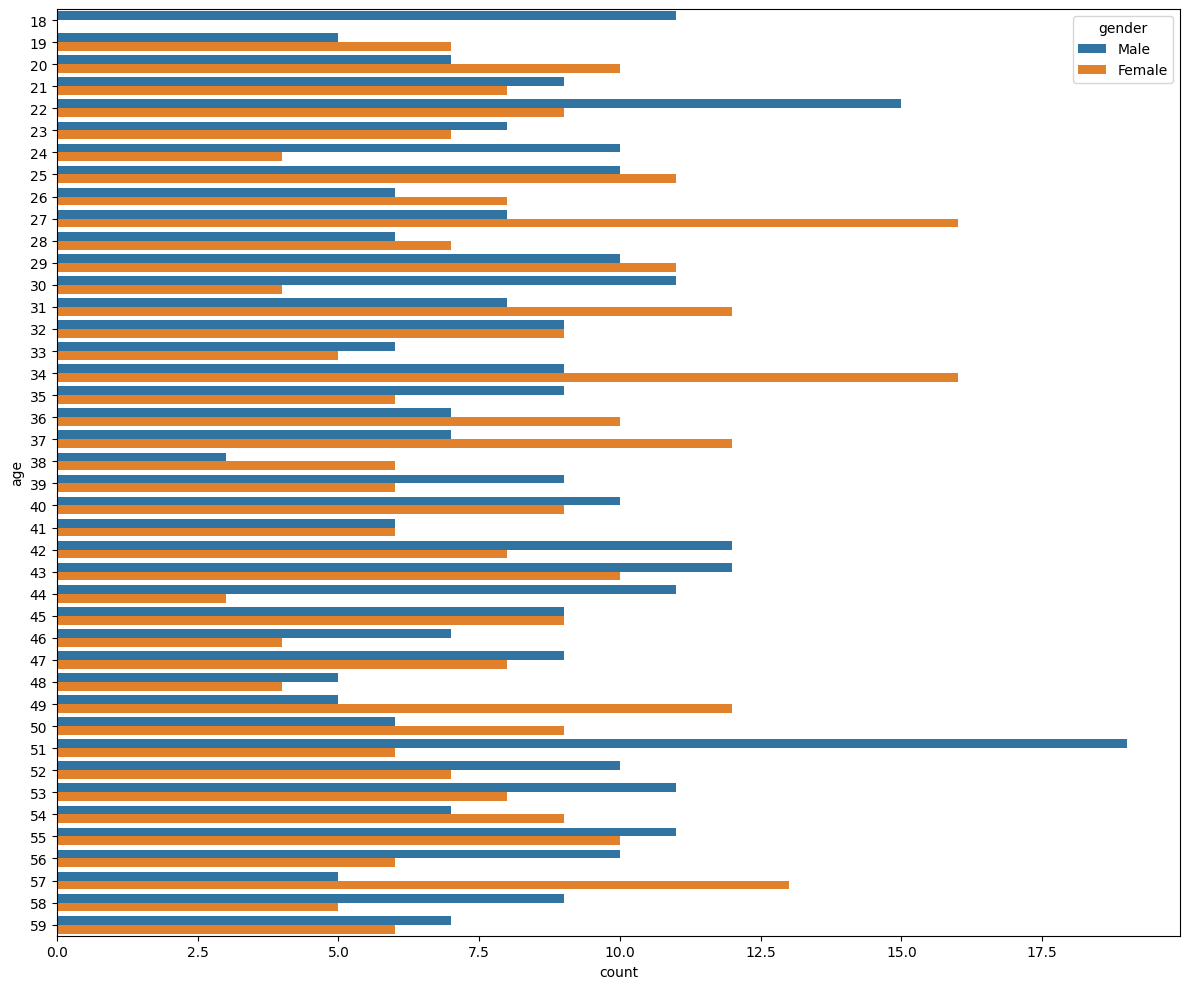

In [19]:
plt.figure(figsize=(12,10))
sns.countplot(y=df['age'], hue =df['gender'])
plt.tight_layout()

From the countplot, we can see that there's no female 18 year old recorded in this dataset

In [20]:
df.loc[(df['age'] == 18) & (df['gender'] == 'Female')]

,device_model,operating_system,app_usage_time(hours/day),screen_on_time(hours/day),battery_drain(mAh/day),number_of_apps_installed,data_usage(mb/day),age,gender,user_behavior_class
User ID,,,,,,,,,,


In [21]:
df.loc[(df['age'] == 18) & (df['gender'] == 'Male')]

,device_model,operating_system,app_usage_time(hours/day),screen_on_time(hours/day),battery_drain(mAh/day),number_of_apps_installed,data_usage(mb/day),age,gender,user_behavior_class
User ID,,,,,,,,,,
44,Samsung Galaxy S21,Android,2.53,3.70,993,32,429,18,Male,Below Average
117,iPhone 12,iOS,1.25,1.20,409,13,281,18,Male,Low
139,Samsung Galaxy S21,Android,8.28,9.70,2876,94,2076,18,Male,High
212,Samsung Galaxy S21,Android,8.02,10.90,2752,86,2017,18,Male,High
259,Xiaomi Mi 11,Android,3.35,4.00,1791,50,914,18,Male,Average
440,Google Pixel 5,Android,2.05,3.90,915,39,468,18,Male,Below Average
562,Xiaomi Mi 11,Android,2.02,2.10,1188,21,578,18,Male,Below Average
570,Google Pixel 5,Android,6.73,6.60,2181,77,1327,18,Male,Above Average
615,Samsung Galaxy S21,Android,1.77,4.00,1158,23,493,18,Male,Below Average


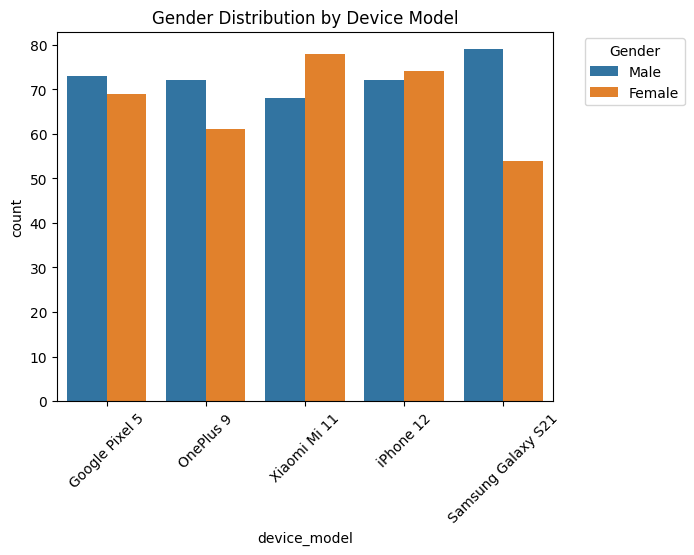

In [22]:
sns.countplot(x='device_model', hue='gender', data=df)
plt.title("Gender Distribution by Device Model")
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [23]:
gender_device_count = df.groupby(['device_model', 'gender']).size().unstack()
gender_device_count

gender,Female,Male
device_model,,
Google Pixel 5,69,73
OnePlus 9,61,72
Samsung Galaxy S21,54,79
Xiaomi Mi 11,78,68
iPhone 12,74,72


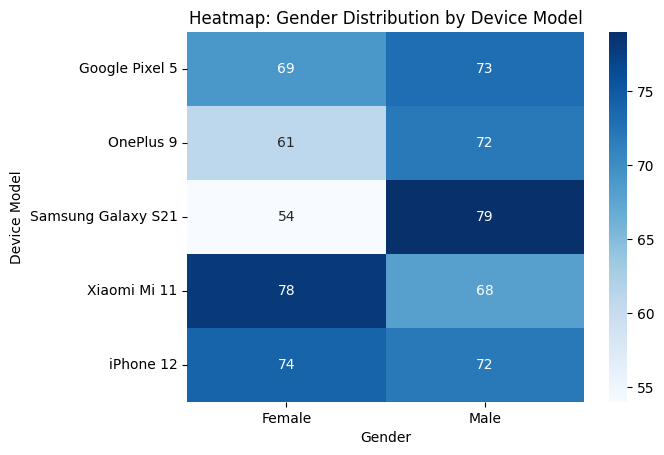

In [24]:
sns.heatmap(gender_device_count, annot=True, cmap='Blues', fmt='g')
plt.title("Heatmap: Gender Distribution by Device Model")
plt.ylabel("Device Model")
plt.xlabel("Gender")
plt.show()

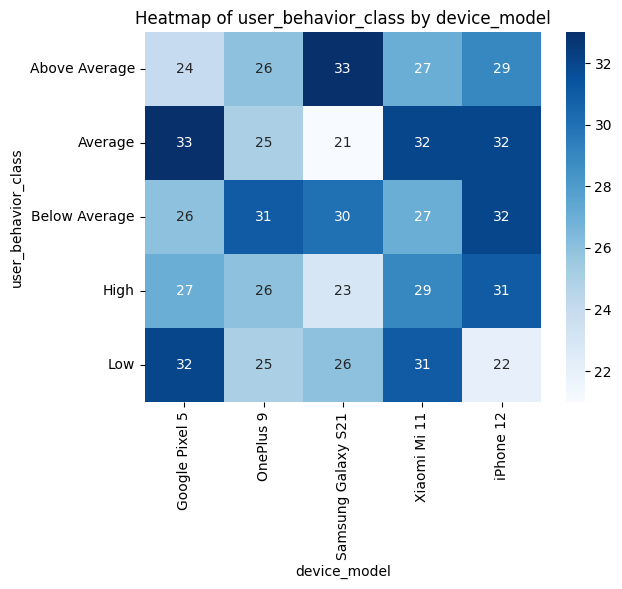

In [25]:
category_count = df.groupby(['user_behavior_class', 'device_model']).size().unstack(fill_value=0)

sns.heatmap(category_count, annot=True, cmap='Blues', fmt='g')
plt.title("Heatmap of user_behavior_class by device_model")
plt.xlabel("device_model")
plt.ylabel("user_behavior_class")
plt.show()

In [26]:
df.head(2)

,device_model,operating_system,app_usage_time(hours/day),screen_on_time(hours/day),battery_drain(mAh/day),number_of_apps_installed,data_usage(mb/day),age,gender,user_behavior_class
User ID,,,,,,,,,,
1,Google Pixel 5,Android,6.55,6.40,1872,67,1122,40,Male,Above Average
2,OnePlus 9,Android,4.47,4.70,1331,42,944,47,Female,Average


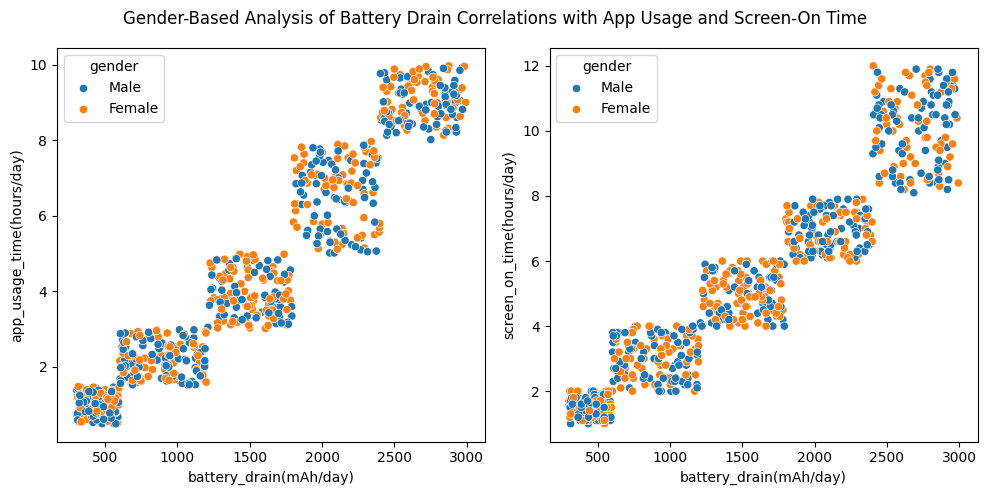

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(x='battery_drain(mAh/day)', y='app_usage_time(hours/day)', data=df, hue='gender', ax=ax[0])
sns.scatterplot(x='battery_drain(mAh/day)', y='screen_on_time(hours/day)', data=df, hue='gender', ax=ax[1])
plt.suptitle('Gender-Based Analysis of Battery Drain Correlations with App Usage and Screen-On Time')
plt.tight_layout()
plt.show()

### Data Preparation for modeling

In [29]:
df_full_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.111, random_state=42)

In [30]:
len(df_train), len(df_test), len(df_val)

(560, 70, 70)

In [31]:
y_train = df_train.pop('user_behavior_class')
y_test = df_test.pop('user_behavior_class')
y_val = df_val.pop('user_behavior_class')

In [32]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [33]:
dv = DictVectorizer(sparse=True)
le = LabelEncoder()

In [34]:
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [35]:
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

### Model selection

In [36]:
def initiate_params():
    params = {
        'Logistic_Regression': {
            'model': LogisticRegression(),
            'params': {
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.1],
            'solver': ['newton-cg', 'liblinear']
            }
        },
        'Decision_Tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [3, 5, 10],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 5, 10]
            }
        },
        'Random_Forest': {
            'model': RandomForestClassifier(),
            'params': {
            'n_estimators': [50, 100],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [None, 10, 20],
            'criterion': ['gini', 'entropy'],
            'n_jobs': [4]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(),
            'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.6, 0.8],
            'colsample_bytree': [0.6, 0.8],
            'n_jobs': [4]
            }
        }
    }

    return params

In [37]:
def random_search_hyperparameter_tuning_classification(X, y, params):
    
    kf = KFold(n_splits=3, shuffle=True, random_state=20)
    results = []

    for key, values in params.items():
        random_search = RandomizedSearchCV(values['model'], values['params'], cv=kf, return_train_score=False, refit=True)
        random_search.fit(X, y)

        results.append({
            'model_name': key,
            'best_score': random_search.best_score_,
            'best_param': random_search.best_params_,
        })

    results_df = pd.DataFrame(results, columns=['model_name', 'best_score', 'best_param'])
    

    return results_df

In [38]:
%time

params = initiate_params()
results = random_search_hyperparameter_tuning_classification(X_train, y_train, params)

CPU times: total: 0 ns
Wall time: 0 ns


In [39]:
pd.set_option('max_colwidth', None)

In [40]:
results

,model_name,best_score,best_param
0,Logistic_Regression,1.00,"{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}"
1,Decision_Tree,1.00,"{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'gini'}"
2,Random_Forest,1.00,"{'n_jobs': 4, 'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}"
3,XGBoost,1.00,"{'subsample': 0.6, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}"


In [41]:
lr = LogisticRegression(C=0.01, penalty='l2', solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_val = lr.predict(X_val)

In [42]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        13

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



In [44]:
test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

y_test = le.transform(y_test)

In [86]:
from sklearn.metrics import roc_curve

In [79]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [88]:
y_pred_test = lr.predict(X_test)

In [89]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        17

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



In [50]:
accuracy_score(y_test, y_pred_test)

1.0

In [110]:
le.inverse_transform(y_pred_test)

array(['Above Average', 'Low', 'Low', 'Below Average', 'Average',
       'Below Average', 'Below Average', 'Low', 'Above Average',
       'Average', 'Low', 'Low', 'Below Average', 'Low', 'Average',
       'Above Average', 'High', 'Low', 'Average', 'Below Average', 'High',
       'Above Average', 'Average', 'Above Average', 'Above Average',
       'Below Average', 'Average', 'High', 'Below Average', 'High', 'Low',
       'Average', 'Low', 'Average', 'Above Average', 'High', 'High',
       'Low', 'Low', 'Below Average', 'Average', 'Above Average', 'Low',
       'Average', 'Below Average', 'High', 'Average', 'Average', 'Low',
       'Average', 'Below Average', 'Below Average', 'Below Average',
       'Low', 'High', 'High', 'Average', 'Low', 'Above Average',
       'Below Average', 'Average', 'Below Average', 'Low',
       'Below Average', 'High', 'Below Average', 'High', 'Low', 'High',
       'High'], dtype=object)

In [90]:
import pickle

In [ ]:
with open("model/lr.bin", "wb") as f_in:
    pickle.dump(lr, f_in)

In [94]:
with open("model/preprocessor.bin", "wb") as f:
    pickle.dump((dv, le), f)

In [114]:
user = df_test.iloc[0]

In [115]:
user = user.to_dict()

In [116]:
user

{'device_model': 'Samsung Galaxy S21',
 'operating_system': 'Android',
 'app_usage_time(hours/day)': 5.066666666666666,
 'screen_on_time(hours/day)': 6.5,
 'battery_drain(mAh/day)': 2375,
 'number_of_apps_installed': 79,
 'data_usage(mb/day)': 1493,
 'age': 51,
 'gender': 'Male'}

In [ ]:
{
    'device': 'Xiaomi Mi 11',
    'operating_system':	'Android',
    'app_usage_time(hours/day)': 154,
    'screen_on_time(hours/day)': 4.00,
    'battery_drain(mAh/day)': 761,
    'number_of_apps_installed':	32,
    'data_usage(mb/day)': 322,
    'age': 42, 
    'gender': 'Male'
}